In [2]:
%matplotlib inline
# Use the Azure Machine Learning data source package
from azureml.dataprep import datasource

# classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# modules to handle data
import pandas as pd
import numpy as np

In [58]:
# load data 
train = datasource.load_datasource('train.dsource')
test = datasource.load_datasource('test.dsource')

# save PassengerId for final submission
passengerId = test.PassengerId

# merge train and test
titanic = train.append(test, ignore_index=True)

# create indexes to separate data later on
train_idx = len(train)
test_idx = len(titanic) - len(test)

In [59]:
#Check all attributes in the context of missing values (NAN)
full_data = [train, test]
#pd.isnull(train).sum() > 0
for dataset in full_data:
    print ("+++++++++++++++++++++++++")
    print(pd.isnull(dataset).sum() > 0)
    print ("+++++++++++++++++++++++++")

+++++++++++++++++++++++++
PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool
+++++++++++++++++++++++++
+++++++++++++++++++++++++
PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin          False
Embarked       False
dtype: bool
+++++++++++++++++++++++++


In [60]:
#Impact of PClass on Traning Data
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0     1.0  0.629630
1     2.0  0.472826
2     3.0  0.242363


In [61]:
#Impact of Sex attribute on Traning Data
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [62]:
#Impact of SibSp attribute on Traning Data
print (train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean())

   SibSp  Survived
0    0.0  0.345395
1    1.0  0.535885
2    2.0  0.464286
3    3.0  0.250000
4    4.0  0.166667
5    5.0  0.000000
6    8.0  0.000000


In [63]:
#Impact of Parch attribute on Traning Data
train['Parch'].astype(int)
print (train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean())

   Parch  Survived
0    0.0  0.343658
1    1.0  0.550847
2    2.0  0.500000
3    3.0  0.600000
4    4.0  0.000000
5    5.0  0.200000
6    6.0  0.000000


In [64]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0         1.0  0.303538
1         2.0  0.552795
2         3.0  0.578431
3         4.0  0.724138
4         5.0  0.200000
5         6.0  0.136364
6         7.0  0.333333
7         8.0  0.000000
8        11.0  0.000000


In [65]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [66]:
#Fill missing Embarked value with mode
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0           1.000000
1        C  0.553571
2        Q  0.389610
3        S  0.336957


In [67]:
#Fare Fare is numerical attribute and it has missing value too. 
#Filling with median fare make sense here and also to apply machine learning classification algorithms, 
#we need to convert this attribute to categorical attributes.
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].
       groupby(['CategoricalFare'], as_index=False).mean())

  CategoricalFare  Survived
0       [0, 7.91]  0.197309
1  (7.91, 14.454]  0.303571
2    (14.454, 31]  0.454955
3   (31, 512.329]  0.581081


In [68]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, 
                                             size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

print (train[['CategoricalAge', 'Survived']].
       groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0    (-0.08, 16]  0.509091
1       (16, 32]  0.363218
2       (32, 48]  0.364662
3       (48, 64]  0.434783
4       (64, 80]  0.090909


In [69]:
import re as re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [70]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [71]:
dataset

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,892.0,3.0,"Kelly, Mr. James",male,34,0.0,0.0,330911,7.8292,,Q,1.0,1,Mr
1,893.0,3.0,"Wilkes, Mrs. James (Ellen Needs)",female,47,1.0,0.0,363272,7.0000,,S,2.0,0,Mrs
2,894.0,2.0,"Myles, Mr. Thomas Francis",male,62,0.0,0.0,240276,9.6875,,Q,1.0,1,Mr
3,895.0,3.0,"Wirz, Mr. Albert",male,27,0.0,0.0,315154,8.6625,,S,1.0,1,Mr
4,896.0,3.0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1.0,1.0,3101298,12.2875,,S,3.0,0,Mrs
5,897.0,3.0,"Svensson, Mr. Johan Cervin",male,14,0.0,0.0,7538,9.2250,,S,1.0,1,Mr
6,898.0,3.0,"Connolly, Miss. Kate",female,30,0.0,0.0,330972,7.6292,,Q,1.0,1,Miss
7,899.0,2.0,"Caldwell, Mr. Albert Francis",male,26,1.0,1.0,248738,29.0000,,S,3.0,0,Mr
8,900.0,3.0,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18,0.0,0.0,2657,7.2292,,C,1.0,1,Mrs
9,901.0,3.0,"Davies, Mr. John Samuel",male,21,2.0,0.0,A/4 48871,24.1500,,S,3.0,0,Mr


In [72]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(float)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0) 
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(float)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
        'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

print (train.head(10))

train = train.dropna()
test = test.dropna()

train_v = train.values
test_v = test.values

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0       0.0     3.0  1.0    1     0       0.0        0      1
1       1.0     1.0  0.0    2     3       1.0        0      3
2       1.0     3.0  0.0    1     1       0.0        1      2
3       1.0     1.0  0.0    2     3       0.0        0      3
4       0.0     3.0  1.0    2     1       0.0        1      1
5       0.0     3.0  1.0    2     1       2.0        1      1
6       0.0     1.0  1.0    3     3       0.0        1      1
7       0.0     3.0  1.0    0     2       0.0        0      4
8       1.0     3.0  0.0    1     1       0.0        0      3
9       1.0     2.0  0.0    0     2       1.0        0      3


In [73]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train_v[0::, 1::]
y = train_v[0::, 0]

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    classifier = KNeighborsClassifier(3)
    classifier.fit(X_train, y_train)
    train_predictions = classifier.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
print ("Accuracy of KNN(3) :%s" % acc)

Accuracy of KNN(3) :0.8426966292134831


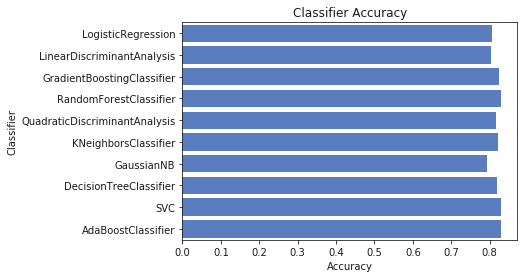

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train_v[0::, 1::]
y = train_v[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [79]:
#Prediction
candidate_classifier = SVC()
candidate_classifier.fit(train_v[0::, 1::], train_v[0::, 0])
result = candidate_classifier.predict(test)
print (result)

[0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.

In [ ]:
df_test = pd.DataFrame({'survived': pd.Series(candidate_classifier.predict(test))})
test = pd.read_csv('../input/test.csv', header = 0, dtype={'Age': np.float64})
test